In [ ]:
!pip install git+https://github.com/Keyi-Li/Distance_Deflation.git

In [2]:
import numpy as np
from scipy.stats import uniform_direction
from distance_deflation import Deflation
from distance_deflation.utils import get_orthogonal_vec, rs_gaussian, neighborhood_dist_overlap

# plotting Setup
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rcParams
import matplotlib.ticker as mtick
rcParams['axes.labelsize'] = 12
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 11
rcParams['axes.titlesize'] = 14
rcParams['axes.grid'] =  True
rcParams['grid.alpha'] =  0.3
rcParams['lines.linewidth'] =  2

## 1. Data Simulation
(see https://www.arxiv.org/pdf/2507.18520 Section 4.2 for details).

Briefly, we follow the following setup:
- **Number of samples:** $n = 1000$  
- **Ambient dimension:** $m = 10{,}000$  
- **Latent representation:** Draw $\theta \sim \text{Uniform}[0, 2\pi]$ and construct points on the unit circle as $
  x(\theta) = (\cos \theta,\, \sin \theta).
  $
- **High-dimensional embedding:** Embed the 2D circle into $\mathbb{R}^m$ using a random orthogonal transformation.  
- **Structured noise:** Add noise whose magnitudes varies smoothly according to $\theta$
  - **magnitude**:  $\left[0,\; 0.1 + 0.9\,\frac{1+\cos\theta}{2}\right]$
  - **direction**: sampled uniformly from the unit sphere in $ \mathbb{R}^m$.


In [3]:
def sample_noise(n: int, m: int, theta: np.ndarray) -> np.ndarray:
    """
    Sample anisotropic noise with magnitude depending on theta.

    noise_mag(theta) in [0.1, 1.0], direction ~ uniform on unit sphere in R^m.
    """

    noise_mag = (0.1 + 0.9 * (1 + np.cos(2 * theta)) / 2).reshape(-1, 1)
    unit_noise_vec = uniform_direction(m).rvs(n)
    return unit_noise_vec * noise_mag

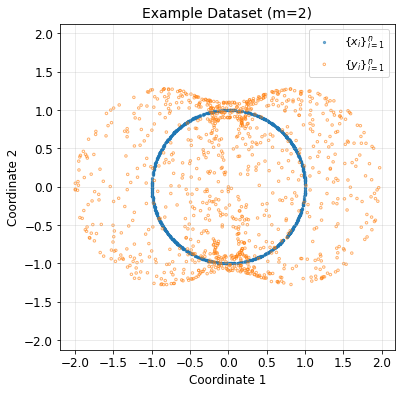

In [4]:
## Example in 2D
np.random.seed(42)

n = 1000
theta = np.random.uniform(size = n) *np.pi*2
theta = np.sort(theta, axis = 0)

noise = sample_noise(n,2,theta)
X_2D_clean =  np.column_stack([np.cos(theta),np.sin(theta)])
# the noisy data here is for visulalization purpose only
X_2D_noisy = X_2D_clean + noise

plt.figure(figsize=(6, 6))
plt.scatter(X_2D_clean[:,0], X_2D_clean[:,1], label=r"$\{x_i\}_{i=1}^n$", c='#1f77b4', s=5, alpha=0.6)
plt.scatter(X_2D_noisy[:,0], X_2D_noisy[:,1], label=r"$\{y_i\}_{i=1}^n$",
                 facecolors='none', edgecolors='#ff7f0e', alpha=0.6, s=6)

plt.title("Example Dataset (m=2)")
plt.axis('equal')
plt.xlabel("Coordinate 1")
plt.ylabel("Coordinate 2");
plt.legend()

In [5]:
m = 10000
U_m = get_orthogonal_vec(m, 2) # orthogonal transformation

# embedding through orthonormal trnasformation and add noise
X_clean = X_2D_clean@U_m.T
noise = sample_noise(n,m, theta)
X_noisy = X_clean + noise

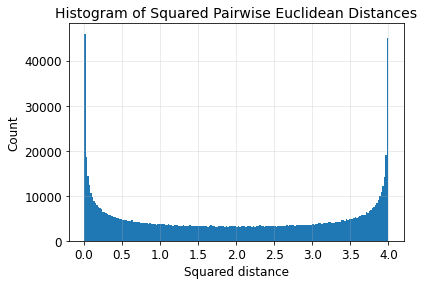

Min Distance:           1.92e-10
5th Percentile:         2.47e-02
10th Percentile:        9.81e-02
25th Percentile:        5.87e-01
Median Distance:        2.00e+00
75th Percentile:        3.42e+00
Max Distance:           4.00e+00


In [6]:
clean_obj = Deflation(X_clean, verbose = True, plot = True, n_jobs = 8)

In [7]:
denoised_obj = Deflation(X_noisy, n_jobs = 8)
denoised_obj.debias_LA() # deflation step

Min Distance:           1.98e-02
5th Percentile:         3.64e-01
10th Percentile:        7.28e-01
25th Percentile:        1.70e+00
Median Distance:        2.78e+00
75th Percentile:        4.01e+00
Max Distance:           6.21e+00


## 2.Analysis

### 2.1 Noise Magnitude Estimation

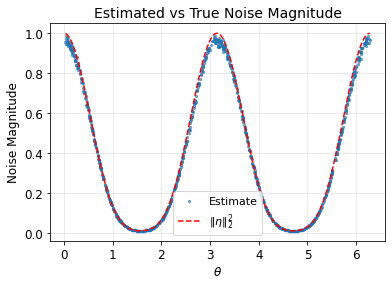

In [8]:
noise_mag = (0.1 + 0.9*(1+np.cos(2*theta))/2).reshape(-1,1) # ground truth squared noise magnitude

plt.scatter(theta, denoised_obj.squared_noise_mag, s=5, alpha=0.6, label= "Estimate")
plt.plot(theta, noise_mag**2, "r--", label=r"$\|\eta\|_2^2$", linewidth=1.5)
plt.ylabel("Noise Magnitude")
plt.xlabel(r"$\theta$")
plt.legend()
plt.title("Estimated vs True Noise Magnitude");

### 2.2 Signal Noise Ratio

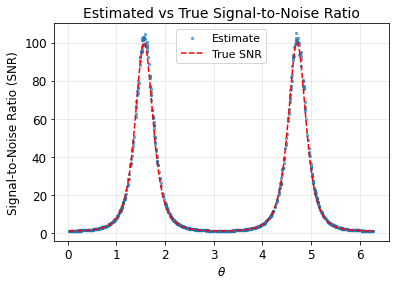

In [9]:
true_sig_mag = np.linalg.norm(X_clean, axis = 1)**2
estimated_sig_mag = np.linalg.norm(X_noisy, axis = 1)**2 - denoised_obj.squared_noise_mag.flatten() # approx

plt.scatter(theta, estimated_sig_mag/denoised_obj.squared_noise_mag.flatten(),
                 s=5, alpha=0.6, label="Estimate")
plt.plot(theta, 1/noise_mag**2, "r--", label="True SNR", linewidth=1.5)
plt.ylabel("Signal-to-Noise Ratio (SNR)")
plt.xlabel(r"$\theta$")
plt.title("Estimated vs True Signal-to-Noise Ratio");
plt.legend()

### 2.3 Distance

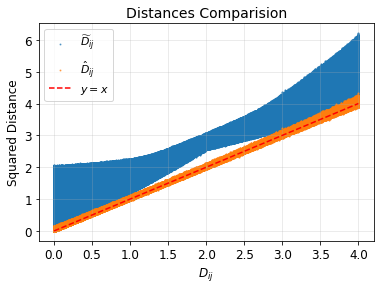

In [10]:
S_distance = clean_obj.S_distance
estimated_S_distance = denoised_obj.denoised
noised_S_distance = denoised_obj.S_distance

mask = ~np.isinf(S_distance) # get rid of digonal element

plt.scatter(S_distance[mask], noised_S_distance[mask],
                 label=r"$\widetilde{D}_{ij}$", s=1, alpha=0.6, rasterized=True)
plt.scatter(S_distance[mask], np.clip(estimated_S_distance[mask], a_min=0, a_max=None),
                 label=r"$\hat{D}_{ij}$", s=1, alpha=0.6, rasterized=True)

# y = x
x = np.linspace(np.min(S_distance),np.max(S_distance[mask]), 100)
plt.plot(x, x, "r--", label=r"$y = x$", linewidth=1.5)

plt.xlabel(r'$D_{ij}$')
plt.ylabel("Squared Distance")
plt.title("Distances Comparision");
plt.legend()

### 2.4 Affinity

In [11]:
## Row Stochastic Gaussian Kernel
bd = 0.5
noise_aff = rs_gaussian(denoised_obj.S_distance, bd)
denoised_aff = rs_gaussian(denoised_obj.denoised, bd)
clean_aff = rs_gaussian(clean_obj.S_distance, bd)

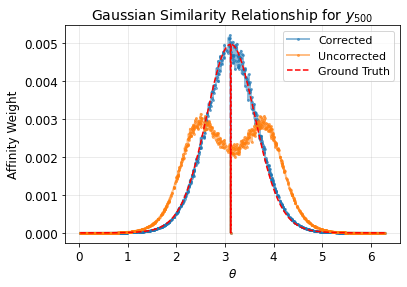

In [13]:
row_idx = 499

plt.plot(theta, denoised_aff[row_idx,:], "o-", label= "Corrected",
               markersize=2, alpha=0.5)
plt.plot(theta, noise_aff[row_idx,:], "o-", label= "Uncorrected",
               markersize=2, alpha=0.5)
plt.plot(theta, clean_aff[row_idx,:], "r--", label= "Ground Truth", linewidth=1.5)

plt.xlabel(r"$\theta$")
plt.ylabel("Affinity Weight")
plt.title(r"Gaussian Similarity Relationship for ${y_{500}}$")
plt.legend()

### 2.5 Near Neighbor Detection

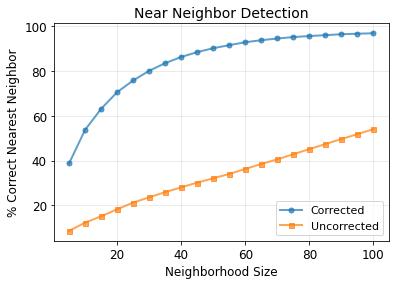

In [14]:
denoised_rate = []
noisy_rate = []
for k in range(5, 101, 5):
    denoised_r, noisy_r = neighborhood_dist_overlap(S_distance, estimated_S_distance, noised_S_distance, k)
    denoised_rate.append(denoised_r)
    noisy_rate.append(noisy_r)

plt.plot(range(5,101,5), 100*np.array(denoised_rate), 'o-',label="Corrected",
                 markersize =5, alpha=0.7, )
plt.plot(range(5, 101, 5), 100*np.array(noisy_rate), 's-', label="Uncorrected",
                 markersize=5, alpha=0.7, )
plt.xlabel("Neighborhood Size")
plt.ylabel("% Correct Nearest Neighbor")
plt.title("Near Neighbor Detection")
plt.legend()